In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import gammapy
gammapy.__version__

'0.20.2.dev625+g5aa8e178b'

In [3]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import PointSkyRegion, CircleSkyRegion

In [4]:
from gammapy.data import DataStore
from gammapy.datasets import Datasets, SpectrumDataset, MapDataset
from gammapy.makers import SpectrumDatasetMaker, FoVBackgroundMaker, SafeMaskMaker, WobbleRegionsFinder, MapDatasetMaker, ReflectedRegionsBackgroundMaker
from gammapy.maps import MapAxis, RegionGeom, Map, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import FoVBackgroundModel


In [5]:
datasets = Datasets.read("$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_datasets.yaml",
                             filename_models="$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_models.yaml")

In [6]:
crab_model = datasets[0].models[0]
crab_model.spectral_model.reference.quantity = 10*u.GeV
crab_model.spectral_model.amplitude.quantity = 1e-8 * u.Unit("cm-2 s-1 TeV-1")

fit = Fit()
result = fit.run(datasets)
print(result)

HDU 'MASK_FIT' not found


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 323
	total stat : -12764.44

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



<AxesSubplot: >

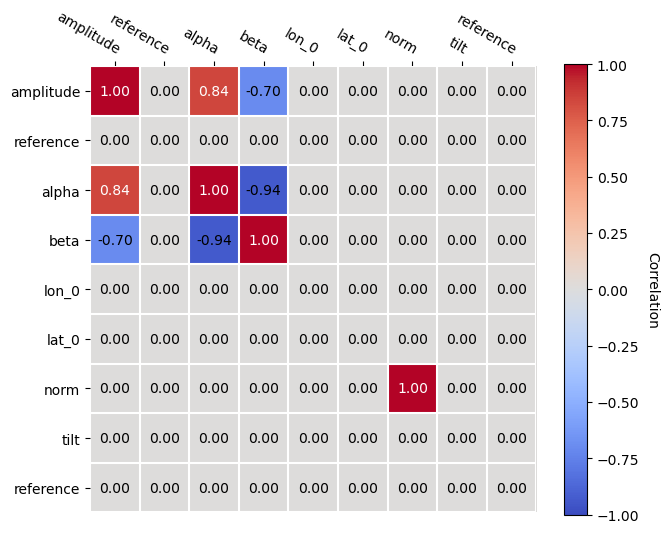

In [7]:
result.models.covariance.plot_correlation()

In [8]:
print(result.models.to_parameters_table())

    model       type      name      value    ...    max    frozen is_norm link
------------- -------- --------- ----------- ... --------- ------ ------- ----
  Crab Nebula spectral amplitude  1.0759e-06 ...       nan  False    True     
  Crab Nebula spectral reference  1.0000e+01 ...       nan   True   False     
  Crab Nebula spectral     alpha  2.2844e+00 ...       nan  False   False     
  Crab Nebula spectral      beta -2.6545e-02 ...       nan  False   False     
  Crab Nebula  spatial     lon_0  8.3633e+01 ...       nan   True   False     
  Crab Nebula  spatial     lat_0  2.2020e+01 ... 9.000e+01   True   False     
Fermi-LAT-bkg spectral      norm  1.3016e+00 ...       nan  False    True     
Fermi-LAT-bkg spectral      tilt  0.0000e+00 ...       nan   True   False     
Fermi-LAT-bkg spectral reference  1.0000e+00 ...       nan   True   False     


<AxesSubplot: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>

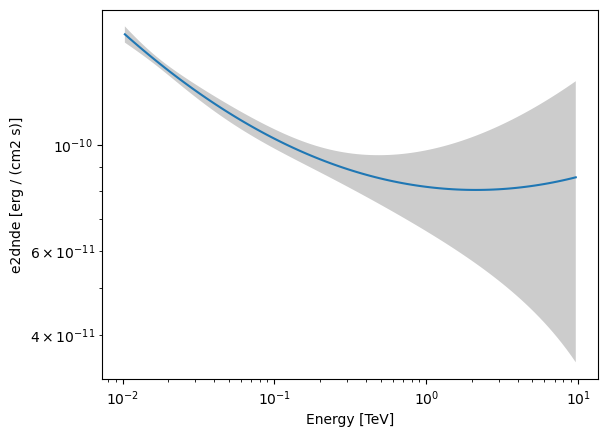

In [9]:
crab_model.spectral_model.plot(energy_bounds=[10*u.GeV, 10*u.TeV], sed_type="e2dnde")
crab_model.spectral_model.plot_error(energy_bounds=[10*u.GeV, 10*u.TeV], sed_type="e2dnde")

In [10]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/magic/rad_max/data")
observations = data_store.get_observations(required_irf="point-like")

In [11]:
crab_model.spatial_model.position

<SkyCoord (ICRS): (ra, dec) in deg
    (83.63310242, 22.01989937)>

In [12]:
target_position = crab_model.spatial_model.position
on_region = PointSkyRegion(target_position)
#on_region = PointSkyRegion(SkyCoord(83.6, 22.0, unit="deg", frame="icrs"))

In [13]:
# true and estimated energy axes
energy_axis = MapAxis.from_energy_bounds(
    50, 1e5, nbin=5, per_decade=True, unit="GeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    10, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy_true"
)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

In [14]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 1 off
region_finder = WobbleRegionsFinder(n_off_regions=3)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-default"])

In [15]:
# create a counts map for visualisation later...
#counts = Map.create(skydir=target_position, width=3)

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
#    counts.fill_events(observation.events)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

No default upper safe energy threshold defined for obs 5029747
No default upper safe energy threshold defined for obs 5029748


In [16]:
e_min = 80 * u.GeV
e_max = 20 * u.TeV

for dataset in datasets[1:]:
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min, e_max)
    dataset.models = [crab_model]

result = fit.run(datasets=datasets)

In [17]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 114
	total stat : -12720.76

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [18]:
result.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str13,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,9.8757e-07,cm-2 s-1 TeV-1,3.408e-08,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+01,GeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.0899e+00,,4.479e-02,nan,nan,False,False,
Crab Nebula,spectral,beta,2.3023e-02,,9.550e-03,nan,nan,False,False,
Crab Nebula,spatial,lon_0,8.3633e+01,deg,0.000e+00,nan,nan,True,False,
Crab Nebula,spatial,lat_0,2.2020e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,
Fermi-LAT-bkg,spectral,norm,1.3021e+00,,7.633e-02,0.000e+00,nan,False,True,
Fermi-LAT-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
Fermi-LAT-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


<AxesSubplot: >

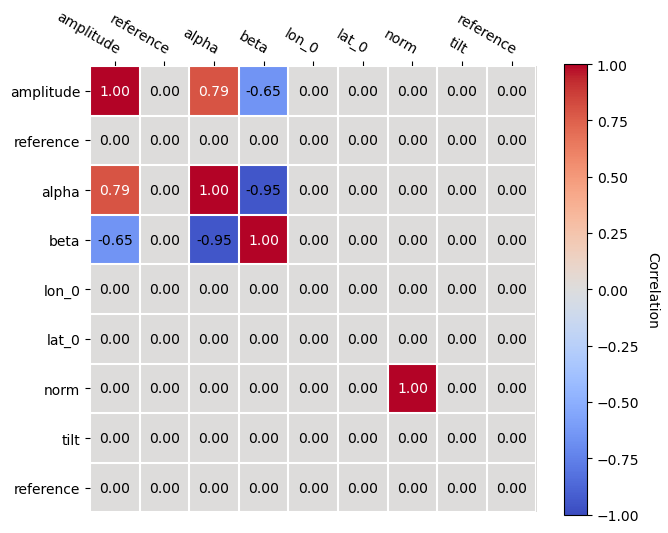

In [19]:
result.models.covariance.plot_correlation()

<AxesSubplot: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>

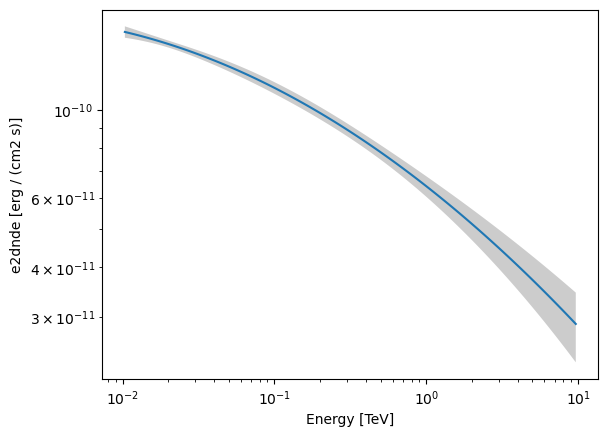

In [20]:
crab_model.spectral_model.plot(energy_bounds=[10*u.GeV, 10*u.TeV], sed_type="e2dnde")
crab_model.spectral_model.plot_error(energy_bounds=[10*u.GeV, 10*u.TeV], sed_type="e2dnde")

In [21]:
data_store_hess = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
hess_observations = data_store_hess.get_observations([23523, 23526, 23559, 23592])

In [22]:
energy_axis = MapAxis.from_energy_bounds(1.0, 10.0, 4, unit="TeV")

geom = WcsGeom.create(
    skydir=(83.633, 22.014),
    binsz=0.02,
    width=(2, 2),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.5, 20, 10, unit="TeV", name="energy_true"
)
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="crab-stacked"
)
offset_max = 2.5 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=offset_max
)
circle = CircleSkyRegion(
    center=SkyCoord("83.63 deg", "22.14 deg"), radius=0.2 * u.deg
)
exclusion_mask = ~geom.region_mask(regions=[circle])
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

for obs in hess_observations:
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.pointing_radec, width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

Background norm obs 23523: 0.99
Background norm obs 23526: 1.08
Background norm obs 23559: 0.99
Background norm obs 23592: 1.10


In [23]:
stacked.models = [crab_model, FoVBackgroundModel(dataset_name=stacked.name)]

In [24]:
datasets.append(stacked)
result = fit.run(datasets=datasets)

In [25]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 128
	total stat : 3545.38

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [26]:
result.models.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str16,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
Crab Nebula,spectral,amplitude,9.6704e-07,cm-2 s-1 TeV-1,3.177e-08,nan,nan,False,True,
Crab Nebula,spectral,reference,1.0000e+01,GeV,0.000e+00,nan,nan,True,False,
Crab Nebula,spectral,alpha,2.0481e+00,,3.719e-02,nan,nan,False,False,
Crab Nebula,spectral,beta,3.2175e-02,,6.556e-03,nan,nan,False,False,
Crab Nebula,spatial,lon_0,8.3633e+01,deg,0.000e+00,nan,nan,True,False,
Crab Nebula,spatial,lat_0,2.2020e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,
Fermi-LAT-bkg,spectral,norm,1.3026e+00,,7.634e-02,0.000e+00,nan,False,True,
Fermi-LAT-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,False,
Fermi-LAT-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,


<AxesSubplot: >

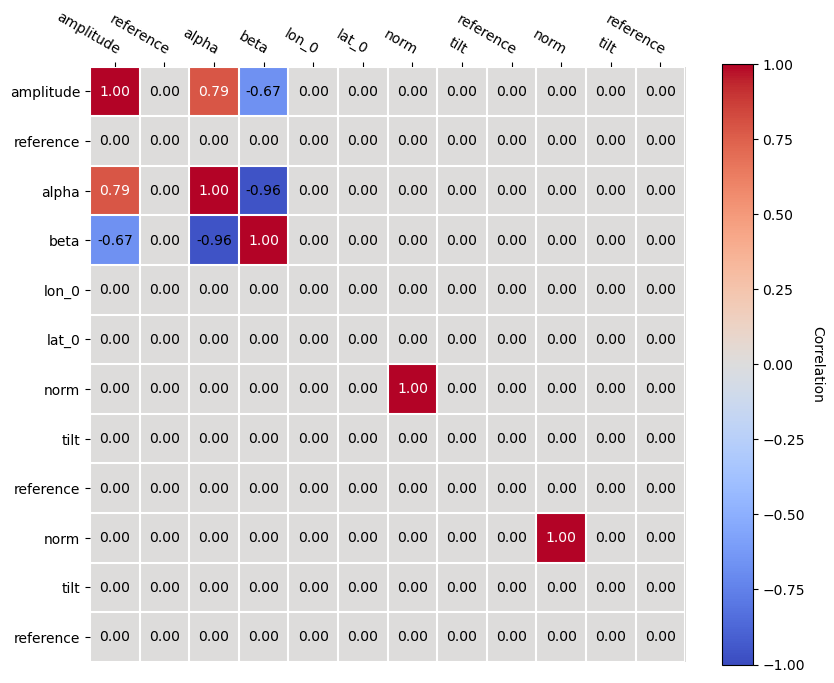

In [27]:
result.models.covariance.plot_correlation()

<AxesSubplot: xlabel='Energy [TeV]', ylabel='e2dnde [erg / (cm2 s)]'>

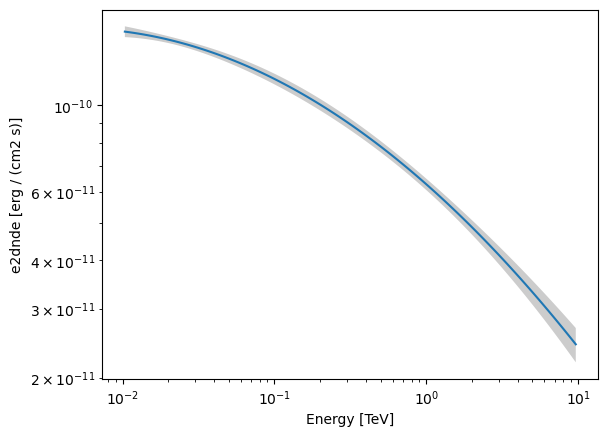

In [28]:
crab_model.spectral_model.plot(energy_bounds=[10*u.GeV, 10*u.TeV], sed_type="e2dnde")
crab_model.spectral_model.plot_error(energy_bounds=[10*u.GeV, 10*u.TeV], sed_type="e2dnde")